# CIFAR-10 luokittelua konvoluutioverkolla
CIFAR-10 datasetti koostuu 60.000 32x32 kuvasta, jotka esittävät 10 eri aihetta.

### Setup
Ensimmäisessä solussa aloitamme asettamalla Kerasille yhteyden Tensorflowiin, sekä tuomme tarvittavat kirjastot

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import backend as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
print(K.backend())

tensorflow


### Mallin kehittäminen ja treenaaminen

Lataamme ensin datan (Cifar-10) ja jaamme sen x- ja y-treeni sekä -testi-seteiksi. Mallin kehittäminen selitetään koodissa kommenteilla.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Muunnetaan kuva pikseleiksi ja skaalataan arvot välille [0, 1]
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Määritetään kuvan esikäsittelykerros
# Zoomaa ja pyörittää kuvaa silleen et se on aina vähän eri näköinen
preprocessing_pipeline = keras.Sequential([
    layers.RandomFlip(),
])

# Layerit CNN mallille
# Input layer on kuvan koko
inputs = keras.Input((32, 32, 3))

# Kuvan esikäsittelykerros
#x = preprocessing_pipeline(inputs)

# Konvoluutio kerros
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)

# Normalisointi kerros joka normalisoi kerroksen outputin keskiarvon ja varianssin
# Tämä nopeuttaa oppimista ja vähentää overfittingiä
x = layers.BatchNormalization()(x)

# Lisätään toinen konvoluutio kerros
x = layers.Conv2D(64, (3, 3), activation='relu')(x)

# Max pooling kerros joka zoomaa kuvaa
# Tämä vähentää kuvan kokoa ja siten vähentää parametrimäärää
x = layers.MaxPooling2D((2, 2))(x)

# Dropout kerros joka tiputtaa osan inputista nollaksi
# Tämä vähentää overfittingiä
x = layers.Dropout(0.2)(x)

# Ja sama uudestaan
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Lopuksi Flatten kerros joka muuttaa 3D tensorin 1D tensoriksi
# Tämä on tarpeellista ennen kuin voidaan käyttää Dense kerroksia (Output on dense kerros)
# Tän jälkeen vois vielä olla jotain dense kerroksia
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

# Määritetään malli
model = keras.Model(inputs=inputs, outputs=outputs, name='cifar10_model')
model.summary()
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(0.002),
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=7,
    min_delta=0.001,
    restore_best_weights=True
    )

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=0.00001
)

# Treeni
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.2, 
                    callbacks=[early_stopping, reduce_lr])

# Annetaan mallille tentti
test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Model: "cifar10_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        23,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,754 (311.54 KB)

 Trainable params: 79,562 (310.79 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.4079 - loss: 1.8221 - val_accuracy: 0.5257 - val_loss: 1.3803 - learning_rate: 0.0020
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.6205 - loss: 1.0877 - val_accuracy: 0.6298 - val_loss: 1.0726 - learning_rate: 0.0020
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.6794 - loss: 0.9189 - val_accuracy: 0.6474 - val_loss: 1.0192 - learning_rate: 0.0020
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.7242 - loss: 0.8015 - val_accuracy: 0.7012 - val_loss: 0.8765 - learning_rate: 0.0020
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.7489 - loss: 0.7287 - val_accuracy: 0.6958 - val_loss: 0.8955 - learning_rate: 0.0020
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.7675 - loss: 0.6747 - val_accuracy: 0.6309 - val_loss: 1.1229 - learning_rate: 0.0020
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.7

### Confusion Matrix

Kun olemme ajaneet tietoaineiston verkkomme läpi, saamme tulokset ja voimme seurata, kuinka tarkka mallimme oli kuva kerrallaan.

Kopioimme y_test-datan varmistaaksemme, että alkuperäinen testiaineisto pysyy muuttumattomana. Sen jälkeen teemme ennusteen x_test-datasta käyttämällä malliamme, jolloin saamme y_pred-arvot. Ajamme molemmat argmax-funktion läpi, mikä helpottaa niiden vertailua keskenään.

Seuraavaksi aloitamme itse sekaannusmatriisin luomisen: määritämme sen koon, kuvakategorioiden nimet, lämpökartan, otsikot ja muut tarvittavat elementit.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


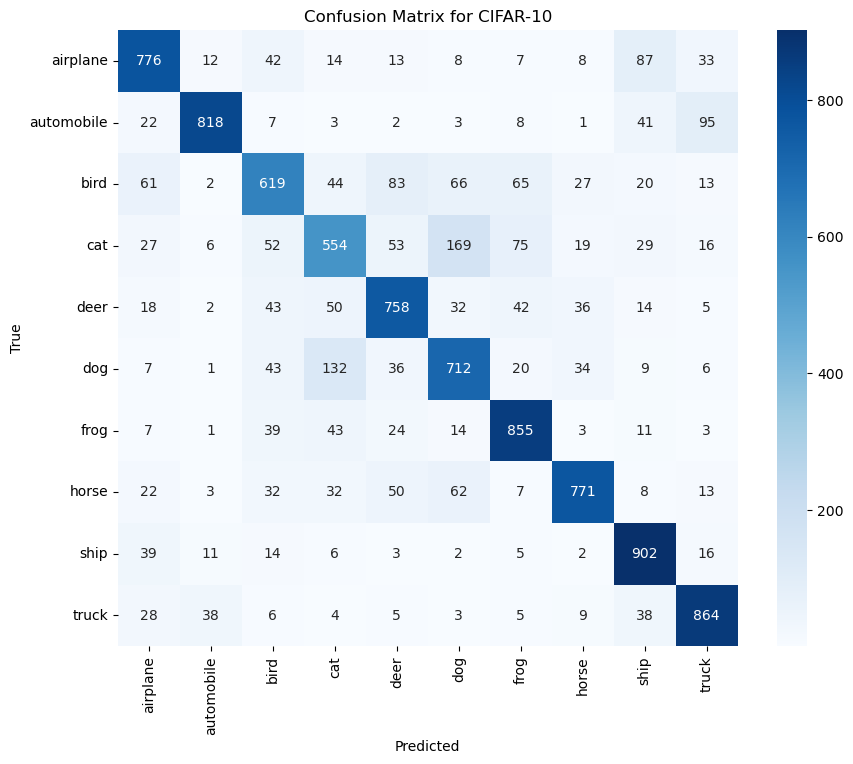

In [5]:
# Confusion matrix
y_test_copy = y_test
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_copy = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_copy, y_pred)
plt.figure(figsize=(10, 8))

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CIFAR-10')
plt.show()

### Analyysi

Mallin tarkkuus oli n. 76 % mikä on huomattava parannus FCN-mallista.

Sekaannusmatriisista voimme nähdä, että mallimme on melko tarkka. Se tunnistaa kuvat enimmäkseen oikein, mutta joitakin poikkeuksia esiintyy. Mallimme teki joitakin virheitä, erityisesti se sekoitti toisinaan kissojen ja koirien kuvia sekä ajoneuvoja keskenään sekä myös luuli lentokoneita laivoiksi tai autoja kuorma-autoiksi.

Mallimme tunnisti kuitenkin suurimman osan kuvista oikein, noin 600–900 kuvaa per luokka. Heikoin kategoria oli kissakuvat, joista malli tunnisti oikein vain noin 550 kappaletta.